# Notebook for running the snmachine pipeline on Supernova Photometric Classification Challenge simulated data

This notebook illustrates the use of the `snmachine` supernova classification package by classifying a subset simulated data from the supernova photometric classification challenge (SPCC). 

See Lochner et al. (2016): http://arxiv.org/abs/1603.00882

NOTE: The results here differ slightly from the paper because we're using a much smaller dataset (in the interest of disk space and speed). Additionally, here the feature extraction methods use least squares (which is must faster) whereas in the paper we used nested sampling for more accurate fits.

<img src="pipeline.png" width=600>

This image illustrates the how the pipeline works. As the user, you can choose what feature extraction method you want to use. Here we have three (four, technically, since there are two parametric models) but it's straighforward to write a new feature extraction method. Once features have been extracted, they can be run through one of several machine learning algorithms and again, it's easy to write your own algorithm into the pipeline. There's a convenience function in `snclassifier` to run a feature set through multiple algorithms and plot the result. The rest of this notebook goes through applying each of the feature extraction methods to a set of simulations and running all feature sets through different classification algorithms.

In [1]:
!pip install ../snmachine/

ERROR: Directory '../snmachine/' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import os

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
from snmachine import example_data, sndata, snfeatures
from utils.plasticc_pipeline import create_folder_structure, get_directories

No module named 'pymultinest'

                PyMultinest not found. If you would like to use, please install
                Mulitnest with 'sh install/multinest_install.sh; source
                install/setup.sh'
                


In [5]:
%config Completer.use_jedi = False  # enable autocomplete

#### Aestetic settings

In [6]:
%matplotlib nbagg

sns.set(font_scale=1.3, style="ticks")

In [ ]:
from __future__ import division
from snmachine import sndata, snfeatures, snclassifier, tsne_plot, example_data
import numpy as np
import matplotlib.pyplot as plt
import time, os, pywt,subprocess
from sklearn.decomposition import PCA
from astropy.table import Table,join,vstack
from astropy.io import fits
import sklearn.metrics 
import sncosmo

In [ ]:
%%capture --no-stdout 
#I use this to supress unnecessary warnings for clarity
%load_ext autoreload
%autoreload #Use this to reload modules if they are changed on disk while the notebook is running
%matplotlib nbagg

## Set up output structure

We make lots of output files so it makes sense to put them in one place. This is the recommended output file structure.

We start by **naming** our analysis.

In [7]:
dataset_name = 'spcc'
analysis_name = os.path.join(f'output_{dataset_name}_no_z')

Then, we **write** in `folder_path` the path where to save the folder.

Note that `MultiNest` uses a hardcoded character limit for the output file names (we believe it is 100 characters). Thus, avoid making this file path to lengthy if using nested sampling otherwise the multinest output file names will be truncated.

In [8]:
folder_path = '.'

Create the folder structure.

In [9]:
create_folder_structure(folder_path, analysis_name)


                Folders already exist with this analysis name.

                Are you sure you would like to proceed, this will overwrite the
                output_spcc_no_z folder [Y/n]
                
Y
Overwriting existing folder..


See the folder structure. We save:
* the extracted features in `directories['features_directory']`
* the classification probabilities and ROC curves in `directories['classifications_directory']`
* the any intermediate files (such as multinest chains or GP fits) in `directories['intermediate_files_directory']`

In [10]:
directories = get_directories(folder_path, analysis_name) 
directories

{'analysis_directory': './output_spcc_no_z',
 'features_directory': './output_spcc_no_z/wavelet_features',
 'classifications_directory': './output_spcc_no_z/classifications',
 'intermediate_files_directory': './output_spcc_no_z/intermediate_files',
 'plots_directory': './output_spcc_no_z/plots'}

In [ ]:
path_saved_features = directories['features_directory']
path_saved_interm = directories['intermediate_files_directory']
path_saved_classifier = directories['classifications_directory']

## Initialise dataset object

Load a subset of the SPCC DES simulated data (http://arxiv.org/abs/1008.1024). For that, we **write** the path where the data is. Alternatively, we can automatically untar the data.

In [12]:
data_path = os.path.join(example_data, 'SPCC_SUBSET', '')

In [13]:
if not os.path.exists(data_path):  # automatically untar the data
    subprocess.call(['tar', '-zxvf', 'SPCC_SUBSET.tar.gz'])

In [14]:
dataset = sndata.Dataset(data_path)

Reading data...
2000 objects read into memory.


For now we restrict ourselves to three supernova types: Ia (1), II (2) and Ibc (3).

In [15]:
types = dataset.get_types()
types['Type'][np.floor(types['Type']/10)==2] = 2
types['Type'][np.floor(types['Type']/10)==3] = 3

Now we can plot all the data and cycle through it (left and right arrows on your keyboard)

<IPython.core.display.Javascript object>


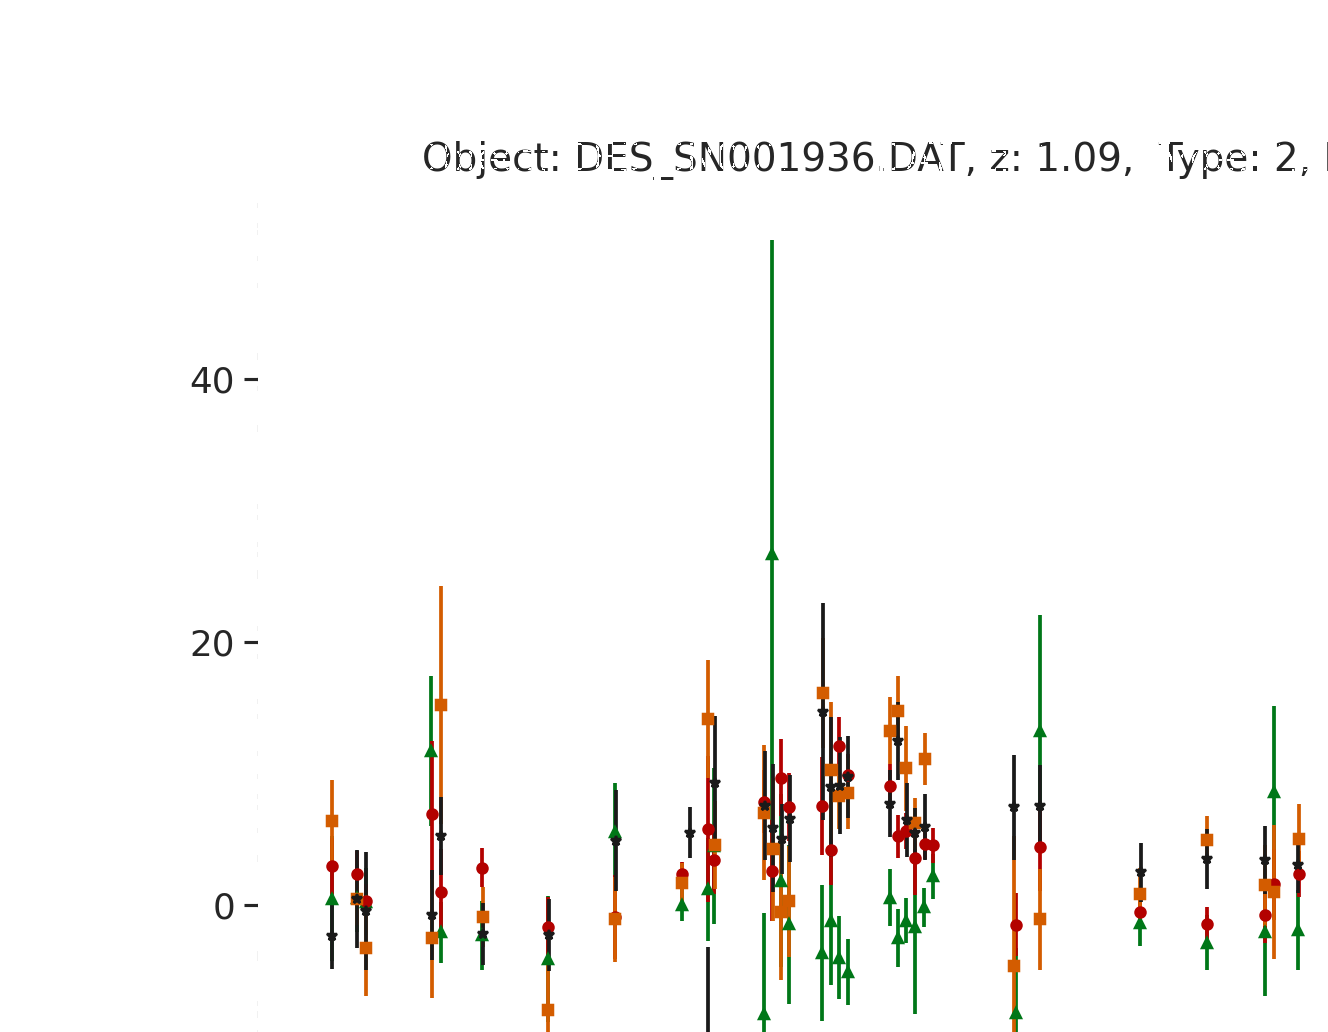

In [16]:
dataset.plot_all()

Each light curve is represented in the Dataset object as an astropy table, compatible with `sncosmo`:

In [17]:
dataset.data[dataset.object_names[0]]

mjd,filter,flux,flux_error,zp,zpsys
float64,str4,float64,float64,float64,str2
0.0,desg,-0.7663,10.48,27.5,ab
0.01600000000325963,desr,3.049,7.841,27.5,ab
0.03200000000651926,desi,0.4541,9.312,27.5,ab
0.9770000000062282,desz,4.622,5.329,27.5,ab
1.985000000000582,desg,0.8938,3.205,27.5,ab
2.0,desr,3.493,2.427,27.5,ab
2.0160000000032596,desi,-2.318,4.311,27.5,ab
9.957000000002154,desz,39.55,27.34,27.5,ab
10.105999999999767,desg,-26.03,25.58,27.5,ab


## Extract features for the data

The next step is to extract useful features from the data. This can often take a long time, depending on the feature extraction method, so it's a good idea to save these to file.

In [18]:
read_from_file = False  # use this flag to quickly rerun from saved features
run_name = os.path.join(path_saved_features, f'{dataset}_all')

### 1. SALT2 Template features

In [19]:
# This is a Features object, not yet the extracted features
salt2_features_instance = snfeatures.TemplateFeatures(sampler='leastsq') 

This performs the actual feature extraction. All feature extraction methods are parallelised with multiprocessing, just set `nprocesses`>1 for parallelisation.

In [34]:
if read_from_file:
    print('Reading from file...')
    salt2_features = Table.read(f'{run_name}_templates.dat', 
                                format='ascii')
    better_name = salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', better_name)
else:
    print('Feature extraction...')
    salt2_features = salt2_features_instance.extract_features(
        dataset, use_redshift=True, number_processes=1, 
        chain_directory=path_saved_interm)
    salt2_features.write(f'{run_name}_templates.dat', format='ascii')

Feature extraction...
Fitting templates using leastsq ...
MODEL-NAME: Ia
0 objects fitted
100 objects fitted
200 objects fitted
300 objects fitted
400 objects fitted
500 objects fitted
600 objects fitted
700 objects fitted
800 objects fitted
900 objects fitted
1000 objects fitted


RuntimeError: result is NaN for [ 0.8576 -52.9033 1.58e-05 1.01815 nan ]

In [32]:
if read_from_file:
    print('Reading from file...')
    salt2_features = Table.read(f'{run_name}_templates.dat', 
                                format='ascii')
    better_name = salt2_features['Object'].astype(str)
    salt2_features.replace_column('Object', better_name)
else:
    print('Feature extraction...')
    salt2_features = salt2_features_instance.extract_features(
        dataset, use_redshift=True, number_processes=4, 
        chain_directory=path_saved_interm)
    salt2_features.write(f'{run_name}_templates.dat', format='ascii')

Feature extraction...
Fitting templates using leastsq ...
MODEL-NAME: Ia


RuntimeError: result is NaN for [ 0.6421 -37.0659 5.13706e-06 nan -0.0445148 ]

Then, we take the fitted parameters and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(salt2_features_instance.fit_sn, salt2_features)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

t-SNE plots: 
These are useful visualisation plots which embed high dimensional features into a lower dimensional space to indicate how well the features separate between classes (see https://lvdmaaten.github.io/tsne/).

In [ ]:
plt.figure()
tsne_plot.plot(salt2_features, join(salt2_features, types)['Type'])

### 2.1 Parametric fits - model 1 (Newling et al.)

In [41]:
model1_features_instance = snfeatures.ParametricFeatures(
    'newling', sampler='leastsq')

In [42]:
%%capture --no-stdout
if read_from_file:
    model1_features = Table.read(f'{run_name}_newling.dat', 
                               format='ascii')
    better_name = mod1_features['Object'].astype(str)
    read_from_file.replace_column('Object', better_name)
else:
    read_from_file = model1_features_instance.extract_features(
        dataset, number_processes=1, chain_directory=path_saved_interm)
    read_from_file.write(f'{run_name}_newling.dat', format='ascii')

0 objects fitted


RuntimeError: pedantic is not one of the parameters []

Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [37]:
for c in mod1_features.colnames[1:]:
    model1_features[c][np.isnan(model1_features[c])] = 0

NameError: name 'mod1_features' is not defined

Finally, we take the features and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(model1_features_instance.fit_sn, model1_features)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

We also make a t-SNE plot.

In [ ]:
plt.figure()
tsne_plot.plot(model1_features, join(model1_features, types)['Type'])

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [38]:
model2_features_instance = snfeatures.ParametricFeatures(
    'karpenka', sampler='leastsq')

In [39]:
%%capture --no-stdout
if read_from_file:
    model2_features = Table.read(f'{run_name}_karpenka.dat', format='ascii')
    better_name = model2_features['Object'].astype(str)
    model2_features.replace_column('Object', better_name)
else:
    model2_features = model2_features_instance.extract_features(
        dataset, number_processes=4, chain_directory=path_saved_interm)
    model2_features.write(f'{run_name}_karpenka.dat', format='ascii')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-75a6e50b62b0>", line 7, in <module>
    dataset, number_processes=4, chain_directory=path_saved_interm)
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/site-packages/snmachine/snfeatures.py", line 1083, in extract_features
    out = p.map(partial_func, d.object_names)
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/multiprocessing/pool.py", line 268, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/multiprocessing/pool.py", line 651, in get
    self.wait(timeout)
  File "/home/calves/.conda/envs/snmachine/lib/python3.7/multiprocessing/pool.py", line 648, in wait
    self._event.wait(timeout)
  File "/home/calves/.conda/envs/snmachine/lib/python3.

KeyboardInterrupt: 

Unfortunately, sometimes the fitting methods return NaN for some parameters for these models.

In [40]:
for c in model2_features.colnames[1:]:
    model2_features[c][np.isnan(model2_features[c])] = 0

NameError: name 'model2_features' is not defined

Finally, we take the features and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(model2_features_instance.fit_sn, model2_features)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

We also make a t-SNE plot.

In [ ]:
plt.figure()
tsne_plot.plot(model2_features, join(model2_features, types)['Type'])

### 3. Wavelet features

The wavelet feature extraction process is quite complicated, although it is fairly fast. Remember to save the PCA eigenvalues, vectors and mean for later reconstruction!

In [ ]:
wavelet_features_instance = snfeatures.WaveletFeatures()

In [ ]:
%%capture --no-stdout
if read_from_file:
    wavelet_features = Table.read(f'{run_name}_wavelets.dat', format='ascii')
    #Crucial for this format of id's
    better_name = wavelet_features['Object'].astype(str)
    wavelet_features.replace_column('Object', better_name)
    PCA_vals = np.loadtxt(f'{run_name}_wavelets_PCA_vals.dat')
    PCA_vec = np.loadtxt(f'{run_name}_wavelets_PCA_vec.dat')
    PCA_mean = np.loadtxt(f'{run_name}_wavelets_PCA_mean.dat')
else:
    wavelet_features = wavelet_features_instance.extract_features(
        dataset, number_processes=4, output_root=path_saved_interm,
        save_output='all')  # TODO -> this will likely fail
    wavelet_features.write(f'{run_name}_wavelets.dat', format='ascii')
    
    PCA_vals = wavelet_features_instance.PCA_eigenvals
    PCA_vec = wavelet_features_instance.PCA_eigenvectors
    PCA_mean = wavelet_features_instance.PCA_mean
    
    np.savetxt(f'{run_name}_wavelets_PCA_vals.dat', PCA_vals)
    np.savetxt(f'{run_name}_wavelets_PCA_vec.dat', PCA_vec)
    np.savetxt(f'{run_name}_wavelets_PCA_mean.dat', PCA_mean)

Finally, we take the features and generate the model light curve for plotting purposes.

In [ ]:
dataset.set_model(wavelet_features_instance.fit_sn,
                  wavelet_features, PCA_vec, PCA_mean, 0, 
                  dataset.get_max_length(), dataset.filter_set)

Now we can see how well the SALT2 model fits our light curves.

In [ ]:
dataset.plot_all()

We also make a t-SNE plot.

In [ ]:
plt.figure()
tsne_plot.plot(wavelet_features, join(wavelet_features, types)['Type'])

## Classify

Finally, we're ready to run the machine learning algorithm. There's a utility function in the `snclassifier` library to make it easy to run all the algorithms available, including converting features to `numpy` arrays and rescaling them and automatically generating ROC curves and metrics. Hyperparameters are automatically selected using a grid search combined with cross-validation. All functionality can also be individually run from `snclassifier`.

Classifiers can be run in parallel, change `number_processes` to the number of processors on your machine (we're only running 4 algorithms so it won't help to set this any higher than 4).

In [ ]:
number_processes = 4

In [ ]:
print('The available classifiers are:', snclassifier.choice_of_classifiers)

In [ ]:
which_column = 0  # SN Ia is the first column

### 1. SALT2 Template features

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=salt2_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 2.1 Parametric fits - model 1 (Newling et al.)

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=model1_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 2.2 Parametric fits - model 2 (Karpenka et al.)

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=model2_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

### 3. Wavelet features

In [ ]:
plt.figure()
classifier_instances, cms = snclassifier.run_several_classifiers(
    classifier_list=['nb','knn','svm','boost_dt'], 
    features=wavelet_features, labels=types,  scoring='accuracy', 
    train_set=.3, scale_features=True, which_column=which_column, 
    random_seed=42, output_root=path_saved_classifier,
    **{'plot_roc_curve': True, 'number_processes': number_processes})

[Go back to top.](#index)